# work74

author: lwg \
date: 2025-04-30

check: haoyanzhen \
date: 2025-05-06

In [2]:
from astropy.io.votable import parse
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, f1_score, accuracy_score, precision_score, recall_score
import seaborn as sns

## 前言

学长，很不好意思在五一假期来临之际打扰你。
在问询你一些问题之后，我进行了改进，但还是遇到了一些我不会解决的问题。
进行星等匹配之后，由于真值太少，就算进行权重分配之后，模型训练效果还是非常不好。

没关系，尽管打扰，我会在有空闲的时候查看和回复，能在你的努力之外帮一点忙也是一件值得欣喜的事。
另外，不知你是否想和唐、于老师一起交流讨论，如果你乐意的话，我找老唐约一个时间。

我会在这份代码里进行一些修改和提议，这些并非强制，只是根据我的经验有一定好处的习惯，以供借鉴和参考

## data load

In [ ]:
# transform gaia catalog data and save
vot_file_path = r'D:\AI\images\1744545913596O-result.vot\1744545913596O-result.vot' 
csv_file_path = 'SH9802CL98051001gaia_catalog.csv' 
votable = parse(vot_file_path)

table = votable.get_first_table()

df = table.to_table().to_pandas()

df.to_csv(csv_file_path, index=False)
print(f"文件已转换为 {csv_file_path}")

文件已转换为 SH9802CL98051001gaia_catalog.csv


In [2]:
# load gaia catalog data and check its ICRS coordinates range
gaia_csv_path = r'D:\github\Work\STUDY\work.7\SH9802CL98051001gaia_catalog.csv'
gaia_df = pd.read_csv(gaia_csv_path)
print("Gaia 星表列名:", gaia_df.columns)

ra_column = 'ra' 
dec_column = 'dec'  

ra_min = gaia_df[ra_column].min()
ra_max = gaia_df[ra_column].max()
dec_min = gaia_df[dec_column].min()
dec_max = gaia_df[dec_column].max()

print(f"赤经范围: {ra_min:.6f} 到 {ra_max:.6f} 度")
print(f"赤纬范围: {dec_min:.6f} 到 {dec_max:.6f} 度")

CSV 文件列名: Index(['solution_id', 'DESIGNATION', 'SOURCE_ID', 'random_index', 'ref_epoch',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       ...
       'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper',
       'ag_gspphot', 'ag_gspphot_lower', 'ag_gspphot_upper',
       'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper',
       'libname_gspphot'],
      dtype='object', length=152)
赤经范围: 15.922007 到 17.597909 度
赤纬范围: 61.739010 到 63.284997 度


Gaia 星表列名: Index(['solution_id', 'DESIGNATION', 'SOURCE_ID', 'random_index', 'ref_epoch',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       ...
       'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper',
       'ag_gspphot', 'ag_gspphot_lower', 'ag_gspphot_upper',
       'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper',
       'libname_gspphot'],
      dtype='object', length=152)
SExtractor 探测到的源:
        FLUX     X_IMAGE  Y_IMAGE
0   2750.145  16881.8008   2.6050
1  12017.330   9850.3408   2.0775
2   3395.846   5599.5967   3.1919
3   3621.705   8605.5000   2.9888
4   3800.678  16523.0117   3.0180
SExtractor 探测到的源的天球坐标:
          RA        DEC
0  17.941474  61.729993
1  16.707625  61.739370
2  15.961482  61.739761
3  16.489118  61.739954
4  17.878544  61.730778


C:\Users\mapleLWG\AppData\Local\Temp\ipykernel_15748\502814132.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sextractor_df = pd.read_csv(sextractor_cat_path, delim_whitespace=True, comment='#', header=None)



所有源（包括匹配成功和失败的）已保存到 SH9802CL98051001_matched_catalog.csv


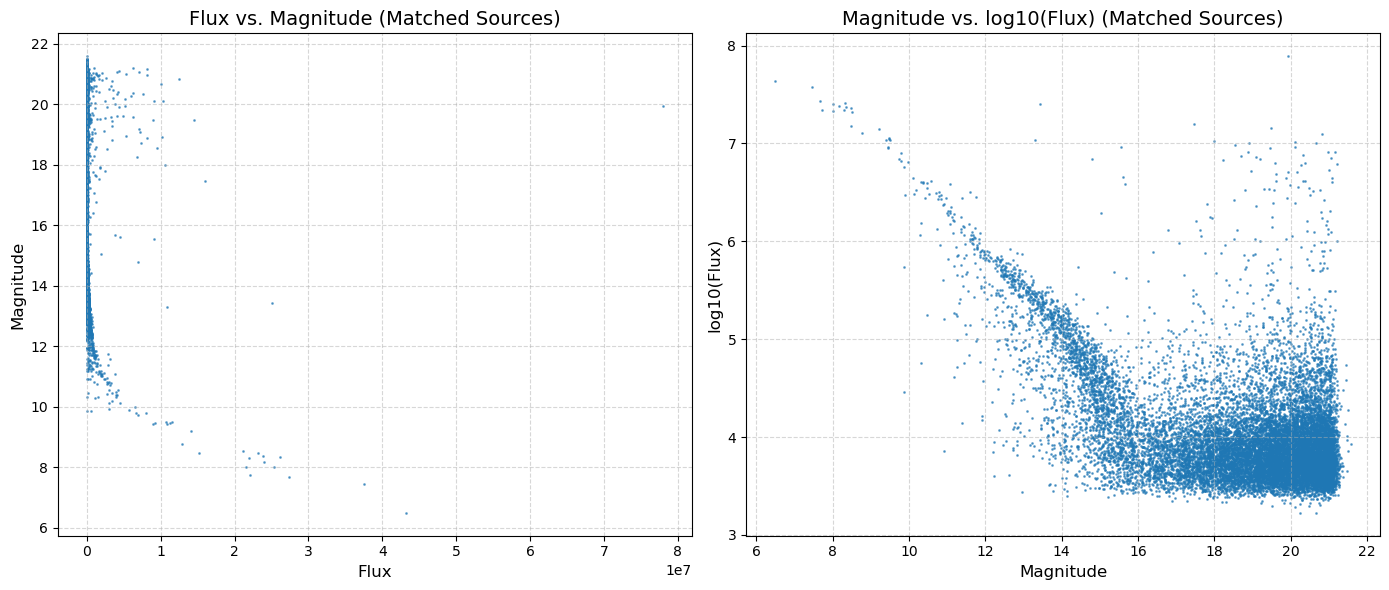

In [ ]:
# load img data and SEx detected data
fits_path = r'D:\AI\images\SH9802CL98051001.fits'
sextractor_cat_path = r'D:\AI\test.cat'
output_csv_path = 'SH9802CL98051001_matched_catalog.csv'

with fits.open(fits_path) as hdul:
    header = hdul[0].header
    wcs = WCS(header)
    data = hdul[0].data

gaia_df['ra'] = pd.to_numeric(gaia_df['ra'], errors='coerce')
gaia_df['dec'] = pd.to_numeric(gaia_df['dec'], errors='coerce')

sextractor_df = pd.read_csv(sextractor_cat_path, delim_whitespace=True, comment='#', header=None)

num_columns = len(sextractor_df.columns)
if num_columns == 3:
    sextractor_df.columns = ['FLUX', 'X_IMAGE', 'Y_IMAGE']
else:
    raise ValueError(f"未知的列数: {num_columns}")

print("SExtractor 探测到的源:")
print(sextractor_df.head())

In [ ]:
# change SEx XY coords to sky coords
sextractor_coords = wcs.all_pix2world(sextractor_df[['X_IMAGE', 'Y_IMAGE']], 0)
sextractor_df['RA'] = sextractor_coords[:, 0]
sextractor_df['DEC'] = sextractor_coords[:, 1]
print("SExtractor 探测到的源的天球坐标:")
print(sextractor_df[['RA', 'DEC']].head())

## first match

without mag for calibrating flux

In [1]:
# choose max distance in matching （选择重要参数量需要有理有据，不盲目扩大，不过分缩小。如果拿不准，可以针对不同参数进行测试）
# calculate as/pixel = deg range / pixel num * (pixel/deg=3600)
1.6/5000*3600  # 1.152
# 每个像素1.15角秒，根据底片质量，最小间隔在5~10像素左右较为合适，即约6~12角秒

1.1520000000000001

In [ ]:
# match
gaia_coords = SkyCoord(ra=gaia_df['ra'].values * u.degree, dec=gaia_df['dec'].values * u.degree)
sextractor_coords = SkyCoord(ra=sextractor_df['RA'].values * u.degree, dec=sextractor_df['DEC'].values * u.degree)

max_separation = 10 * u.arcsec  # max sky coord distance set

idx, d2d, _ = sextractor_coords.match_to_catalog_sky(gaia_coords)

sex_matched_mask = d2d < max_separation
sextractor_df['MATCHED'] = sex_matched_mask.astype(int)
sextractor_df['SEPARATION'] = d2d.arcsec

In [ ]:
# add gaia mag to SEx catalog for successfully matched objects
if 'phot_g_mean_mag' in gaia_df.columns:
    sextractor_df['GAIA_MAG'] = np.nan
    sextractor_df.loc[sex_matched_mask, 'GAIA_MAG'] = gaia_df.iloc[idx[sex_matched_mask]]['phot_g_mean_mag'].values

sextractor_df.to_csv(output_csv_path, index=False)
print(f"\n所有源（包括匹配成功和失败的）已保存到 {output_csv_path}")

matched_sources = sextractor_df[sex_matched_mask]

# plot mag-flux fig for matched objects
if len(matched_sources) == 0:
    raise ValueError("匹配成功的源为空，无法绘制散点图。")

flux = matched_sources['FLUX'].values
gaia_mag = matched_sources['GAIA_MAG'].values

valid_mask = (~np.isnan(flux)) & (~np.isinf(flux)) & (flux > 0) & (~np.isnan(gaia_mag)) & (~np.isinf(gaia_mag))
flux = flux[valid_mask]
gaia_mag = gaia_mag[valid_mask]
# comment:: 不如保存匹配星表的时候就用这种有效样本来保存？

if len(valid_mask) == 0:
    raise ValueError("有效数据为空，无法绘制散点图。")
plt.figure(figsize=(14, 6))

# 第一幅图：流量与星等的关系
# comment:: 这幅图的科学意义很难提取，可以考虑去除
plt.subplot(121)
plt.scatter(flux, gaia_mag, alpha=0.6, s=1)  
plt.xlabel('Flux', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.title('flux - mag  (for Matched Sources)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# 第二幅图：星等与log10流量的关系
plt.subplot(122)
plt.scatter(gaia_mag, flux, alpha=0.6, s=1)  
plt.xlabel('Magnitude', fontsize=12)
plt.xticks(np.arange(6,23))
plt.ylabel('log10(Flux)', fontsize=12)
plt.yscale('log')  # comment:: 用yscale更好，有一个小刻度可以辅助更好的对比指数数量
plt.title('mag-flux  (for Matched Sources)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('./firstmatch_mag-flux.png')  # comment:: 如有必要，可以将图片保存下来，放在如media之类的文件夹中

In [ ]:
# 以下是一个简单的测试参数的示例，用于测试不同的匹配最大距离对匹配数量和有效匹配星等-流量分布图的影响：
def test_max_separation(max_separation_list):
    # 绘制一个三列n行的画布用于汇总结果
    fig_width = 3
    fig_height = max_separation_list//3
    fig, axes = plt.subplots(nrows = fig_height, ncols=fig_width)
    fig.set_size_inches(fig_width*4, fig_height*3)

    # 单步测试
    for id, max_separation in enumerate(max_separation_list):
        # match
        gaia_coords = SkyCoord(ra=gaia_df['ra'].values * u.degree, dec=gaia_df['dec'].values * u.degree)
        sextractor_coords = SkyCoord(ra=sextractor_df['RA'].values * u.degree, dec=sextractor_df['DEC'].values * u.degree)
        idx, d2d, _ = sextractor_coords.match_to_catalog_sky(gaia_coords)

        # extract mag and flux from valid matches
        sex_matched_mask = d2d < max_separation
        flux = sextractor_df['FLUX'].values[sex_matched_mask]
        gaia_mag = gaia_df.iloc[idx, 'phot_g_mean_mag'].values[sex_matched_mask]
        valid_mask = (~np.isnan(flux)) & (~np.isinf(flux)) & (flux > 0) & (~np.isnan(gaia_mag)) & (~np.isinf(gaia_mag))
        flux = flux[valid_mask]
        gaia_mag = gaia_mag[valid_mask]
        if valid_mask.sum() == 0:
            raise ValueError("有效数据为空，无法绘制散点图。")
        else:
            print("有效的匹配数: ", valid_mask.sum())
        
        # plot
        ax = axes[id]
        ax.figure(figsize=(6, 6))
        ax.scatter(gaia_mag, flux, alpha=0.6, s=1)  
        ax.xlabel('Magnitude', fontsize=12)
        ax.xticks(np.arange(6,23))
        ax.ylabel('log10(Flux)', fontsize=12)
        ax.yscale('log')
        ax.set_title('mag-flux  ms: %.2f' % max_separation, fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.tight_layout()
    
    return

test_max_separation(np.linspace(3, 15, 12)* u.arcsec)

## flux calibration

初始数据范围: 6.49 到 14.49 星等, 1231 个点
清洗后: 945/1231 个点 (76.8%)
断点: 12.95 星等
拟合结果:
亮星 (星等<=12.95): log10(流量) = -0.4479*星等 + 11.1049
暗星 (星等>12.95): log10(流量) = -0.0035*星等² + -0.3061*星等 + 9.9090


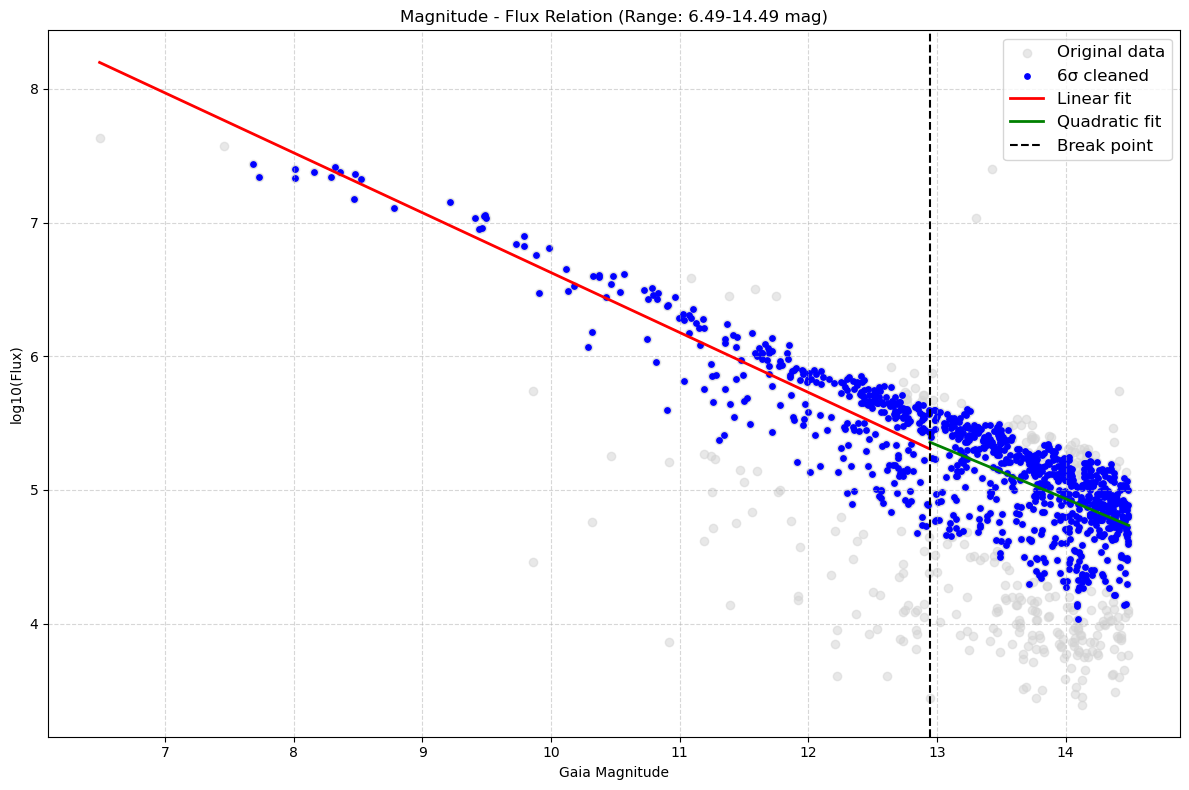

仅包含 xy 匹配成功且流量和星等匹配成功的数据已保存到 ok.csv 文件中


In [3]:
# reload data
output_csv_path = 'SH9802CL98051001_matched_catalog.csv'
sextractor_df = pd.read_csv(output_csv_path)

matched_sources = sextractor_df[sextractor_df['MATCHED'] == 1]
flux = matched_sources['FLUX'].values
mag = matched_sources['GAIA_MAG'].values

valid = (~np.isnan(flux)) & (~np.isinf(flux)) & (flux > 0) & (~np.isnan(mag))
flux = flux[valid]
mag = mag[valid]

if len(mag) == 0:
    print("未找到有效的匹配源")
    exit()
    # comment:: 建议使用raise的方式来中断程序并提醒用户错误原因

In [ ]:
# choose fit range
min_mag = np.min(mag)
upper_mag = min_mag + 8
selected = (mag >= min_mag) & (mag <= upper_mag)
mag_ranged = mag[selected]
log_flux_ranged = np.log10(flux[selected])
# comment:: 这里的策略有点问题，因为对于mag最小的星，也就是最亮的星，在底片上一定会出现，
# 但是由于观测系统的极限，在底片上的测量流量并非它原本的流量——超出阈值的部分就会损失掉了。
# 也就是说，如果你用的是mag最小的星，它很有可能是超出了底片观测的动态范围极限的，而且不同底片
# 的动态范围也不固定。这里建议人工按照有明显的flux-mag趋势的部分进行范围选取，比如
# 在这幅图像里可能选取8~15.5或8~16
# 注意：选取的星等上限会极大影响参与拟合的数据数量

print(f"初始数据范围: {min_mag:.2f} 到 {upper_mag:.2f} 星等, {len(mag_ranged)} 个点")

# clean data
n_sigma = 1

sort_idx = np.argsort(mag_ranged)
mag_sorted = mag_ranged[sort_idx]
log_flux_sorted = log_flux_ranged[sort_idx]

window_points = int(len(mag_sorted)/20)  
if window_points < 5: window_points = 5
smoothed = uniform_filter1d(log_flux_sorted, size=window_points)

residuals = log_flux_sorted - smoothed
std = np.std(residuals)

keep_idx = np.abs(residuals) < n_sigma * std
mag_clean = mag_sorted[keep_idx]
log_flux_clean = log_flux_sorted[keep_idx]
# comment:: 这种平滑剔除还是第一次见！很有意思。一般的clean是分bin来剔除，或者通过
# 拟合-拟合后的残差SigmaClip-再拟合等手段来清洗数据。理论上说清洗数据只要有效就好，
# 只是去除的点是不是过多？看上去有些有效匹配被清洗掉了，特别是暗端部分

print(f"清洗后: {len(mag_clean)}/{len(mag_ranged)} 个点 ({len(mag_clean)/len(mag_ranged):.1%})")

In [ ]:
# fit
def linear_func(x, a, b):
    return a * x + b

def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

split_point = np.percentile(mag_clean, 33)
print(f"断点: {split_point:.2f} 星等")
# comment:: 为什么用33%作为分段？正常情况下应当通过曲线趋势来判断是否分段以及分段点

mask1 = mag_clean <= split_point  
mask2 = mag_clean > split_point   

popt1, _ = curve_fit(linear_func, mag_clean[mask1], log_flux_clean[mask1])
popt2, _ = curve_fit(quadratic_func, mag_clean[mask2], log_flux_clean[mask2])

print("拟合结果:")
print(f"亮星 (星等<={split_point:.2f}): log10(流量) = {popt1[0]:.4f}*星等 + {popt1[1]:.4f}")
print(f"暗星 (星等>{split_point:.2f}): log10(流量) = {popt2[0]:.4f}*星等² + {popt2[1]:.4f}*星等 + {popt2[2]:.4f}")
# comment:: 二次函数的数据段太短，相对于二次函数本身而言只占很小一部分，而且上面的数据挑选中没有选择暗弱的星，因此在实际使用时
# 这个二次函数一定会在拟合所用数据基础上外推，且这样的拟合很容易产生外推的较大误差，建议在绘图时把整个二次函数画出来，特别是星等
# 超出了14.5以后的部分，来和全部的匹配数据做个对比，看看外推符不符合实际数据

# plot fit result
plt.figure(figsize=(12, 8))

plt.scatter(mag_ranged, log_flux_ranged, c='lightgray', alpha=0.5, label='Original data')
plt.scatter(mag_clean, log_flux_clean, c='blue', s=15, label='6σ cleaned')  # comment:: 为什么说是6sigma cleaned？

x_fit1 = np.linspace(min_mag, split_point, 50)
x_fit2 = np.linspace(split_point, upper_mag, 50)
plt.plot(x_fit1, linear_func(x_fit1, *popt1), 'r-', lw=2, label='Linear fit')
plt.plot(x_fit2, quadratic_func(x_fit2, *popt2), 'g-', lw=2, label='Quadratic fit')

plt.axvline(split_point, color='k', linestyle='--', label='Break point')
plt.xlabel('Gaia Magnitude')
plt.ylabel('log10(Flux)')
plt.title(f'Magnitude - Flux Relation (Range: {min_mag:.2f}-{upper_mag:.2f} mag)')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()


## calculate detected mag and match

In [ ]:
# calculate detected mag using fit result of flux calibration
sextractor_df['CALCULATED_MAG'] = np.nan
for i, row in sextractor_df.iterrows():
    flux_val = row['FLUX']
    if pd.notna(flux_val) and flux_val > 0:
        log_flux_val = np.log10(flux_val)
        if log_flux_val <= linear_func(split_point, *popt1):
            sextractor_df.at[i, 'CALCULATED_MAG'] = (log_flux_val - popt1[1]) / popt1[0]
        else:
            a, b, c = popt2
            discriminant = b**2 - 4 * a * (c - log_flux_val)
            if discriminant >= 0:
                root1 = (-b + np.sqrt(discriminant)) / (2 * a)
                root2 = (-b - np.sqrt(discriminant)) / (2 * a)
                sextractor_df.at[i, 'CALCULATED_MAG'] = root1 if root1 > root2 else root2
                # comment:: 为了方便，也可以把拟合中的x改为log10(flux)，y改为mag

# # example of another way to calculate detected mag: （逐行处理会按表格长度增加运算时间）
# # y<c-b^2/4a即有解，c-b^2/4a=9.909，所有流量均小于10^9.909，且二次函数对称轴为负数，可以判断所有解均为右侧解
# flux_first_part = sextractor_df.loc[np.log10(sextractor_df['FLUX']) <= linear_func(split_point, *popt1), 'FLUX']
# flux_second_part = sextractor_df.loc[np.log10(sextractor_df['FLUX']) > linear_func(split_point, *popt1), 'FLUX']
# sextractor_df['DET_MAG'] = (flux_first_part - popt1[1]) / popt1[0]
# sextractor_df['DET_MAG'] = (-popt2[1] + (popt2[1]**2-4*popt2[0]*(popt2[2]-flux_second_part))**0.5) / 2*popt2[0]


In [ ]:
# mag match
matching_threshold = 1  # 1星等的差异表示流量比为2.5倍
sextractor_df['FLUX_MAG_MATCHED'] = 0
for i, row in sextractor_df.iterrows():
    calculated_mag = row['CALCULATED_MAG']
    gaia_mag = row['GAIA_MAG']
    if pd.notna(calculated_mag) and pd.notna(gaia_mag):
        if np.abs(calculated_mag - gaia_mag) <= matching_threshold:
            sextractor_df.at[i, 'FLUX_MAG_MATCHED'] = 1

# # example of another way to match mag:
# valid_mag_mask = (~sextractor_df['GAIA_MAG'].isna()) & (~sextractor_df['CALCULATED_MAG'].isna())
# sextractor_df['MAG_GAP'] = sextractor_df.loc[valid_mag_mask, 'CALCULATED_MAG'] - sextractor_df.loc[valid_mag_mask, 'GAIA_MAG']
# mag_gap = sextractor_df.loc[~sextractor_df["MAG_GAP"].isna(), "MAG_GAP"]
# mag_gap.hist(grid=True, bins=20)
# std = np.inf
# new_std = mag_gap.std()
# while np.abs(new_std - std) > 0.1 and new_std > 0.2:
#     std = new_std
#     mag_matched_mask = mag_gap.abs() <= 3*std
#     mag_gap = mag_gap.loc[mag_matched_mask]
#     new_std = mag_gap.std()
# mag_gap.hist(grid=True)
# sextractor_df['FLUX_MAG_MATCHED'] = 0
# sextractor_df.loc[mag_gap.index, 'FLUX_MAG_MATCHED'] = 1
# print("after sigma-clipping, number of objects: %d, mag gap std: %.2f" % (sextractor_df['FLUX_MAG_MATCHED'].sum(), new_std))

sextractor_df['FINAL_MATCHED'] = (sextractor_df['MATCHED'] == 1) & (sextractor_df['FLUX_MAG_MATCHED'] == 1)
print("len of whole data: %d, \nloc matched: %d, \ndetected mag matched: %d, \ntwo matched: %d" %
      (len(sextractor_df), sextractor_df['MATCHED'].sum(), sextractor_df['FLUX_MAG_MATCHED'].sum(), sextractor_df['FINAL_MATCHED'].sum()))

sextractor_df.to_csv('okok.csv', index=False)
print("仅包含 xy 匹配成功且流量和星等匹配成功的数据已保存到 okok.csv 文件中")

In [ ]:
file_path = 'okok.csv'

try:
    df = pd.read_csv(file_path)

    if 'FINAL_MATCHED' in df.columns:
        true_count = (df['FINAL_MATCHED'] == 1).sum()
        false_count = (df['FINAL_MATCHED'] == 0).sum()
        total_count = len(df)
        
        true_ratio = true_count / total_count * 100
        false_ratio = false_count / total_count * 100
        
        print("数据分布统计:")
        print(f"总样本数: {total_count}")
        print(f"真值(1)数量: {true_count} ({true_ratio:.2f}%)")
        print(f"假值(0)数量: {false_count} ({false_ratio:.2f}%)")
        
    else:
        print("错误: 匹配文件中不存在名为 FINAL_MATCHED 的列。")
        print("可用列名为:", df.columns.tolist())
        
except FileNotFoundError:
    print(f"错误: 找不到文件: {file_path}")
    

数据分布统计:
总样本数: 57230
真值(1)数量: 3069 (5.36%)
假值(0)数量: 54161 (94.64%)


## distinguish true and false sources

### make dataset


=== 清洗后的数据 ===
               FLUX       X_IMAGE       Y_IMAGE            RA           DEC  \
count  1.632900e+04  16329.000000  16329.000000  16329.000000  16329.000000   
mean   9.232959e+04   9787.936358   9631.160074     16.707261     62.538921   
std    1.109909e+06   2727.965956   5738.066599      0.490232      0.477211   
min    1.678838e+03   5359.191400      2.077500     15.916340     61.736508   
25%    4.825071e+03   7332.890600   4033.501500     16.265517     62.072852   
50%    7.554933e+03   9819.305700  10322.390600     16.712722     62.595851   
75%    1.517895e+04  12070.430700  14949.992200     17.118266     62.981286   
max    7.799604e+07  14928.373000  18583.414100     17.603163     63.280754   

       XY_MATCHED    SEPARATION      GAIA_MAG  CALCULATED_MAG  \
count     16329.0  16329.000000  16329.000000    16329.000000   
mean          1.0      4.963596     18.632675       15.784463   
std           0.0      2.677853      2.305525        1.219395   
min         

C:\Users\mapleLWG\AppData\Local\Temp\ipykernel_28812\900683874.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


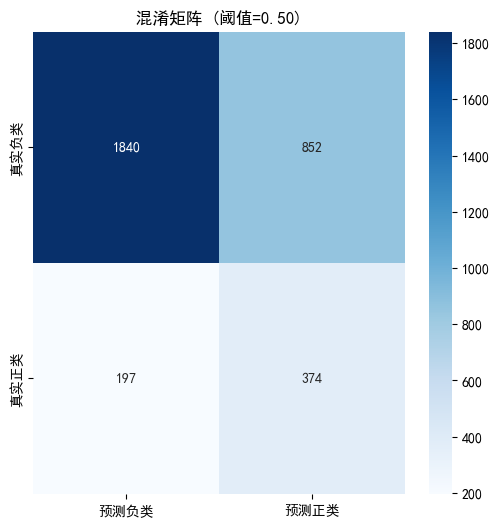


最优阈值: 0.6388 (默认0.5)

=== 最优阈值评估 ===

=== 分类报告 ===
              precision    recall  f1-score   support

          负类       0.89      0.95      0.92      2692
          正类       0.67      0.46      0.54       571

    accuracy                           0.86      3263
   macro avg       0.78      0.70      0.73      3263
weighted avg       0.85      0.86      0.85      3263

AUC-ROC: 0.7578
Average Precision: 0.5633


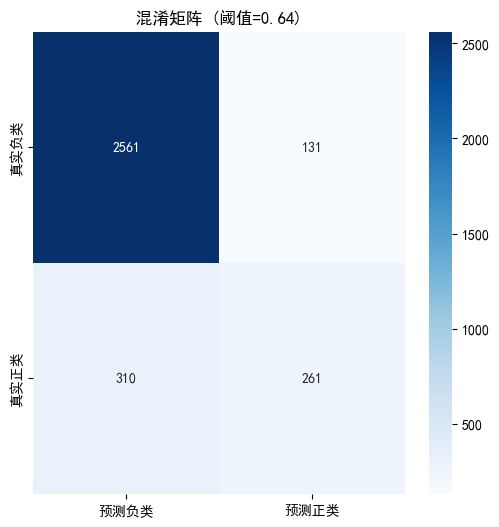

In [ ]:
# load data and show catalog info
plt.rcParams['font.family'] = 'SimHei'

fits_image = fits.open(r'D:\AI\images\SH9802CL98051001.fits')
data = fits_image[0].data

okok_df = pd.read_csv(r'okok.csv')

okok_df_cleaned = okok_df.dropna(subset=['GAIA_MAG'])

print("\n=== 清洗后的数据 ===")
print(okok_df_cleaned.describe())

valid_samples = okok_df_cleaned[okok_df_cleaned['GAIA_MAG'] >= 0]

print(f"有效样本数: {valid_samples.shape[0]}")

if valid_samples.shape[0] == 0:
    print("没有有效的样本，请检查筛选条件。")
else:
    min_mag = valid_samples['GAIA_MAG'].min()
    max_mag = valid_samples['GAIA_MAG'].max()
    print(f"最小星等: {min_mag}, 最大星等: {max_mag}")


In [ ]:
# make input data
x_positions = valid_samples['X_IMAGE'].values
y_positions = valid_samples['Y_IMAGE'].values
labels = valid_samples['FINAL_MATCHED'].values

patch_size = 16  # comment:: 一颗星有这么大吗
patches = []
valid_labels = []
for x, y, label in zip(x_positions, y_positions, labels):
    x, y = int(round(x)), int(round(y))
    x_min, x_max = x - patch_size//2, x + patch_size//2
    y_min, y_max = y - patch_size//2, y + patch_size//2

    if all([x_min >=0, x_max < data.shape[1], y_min >=0, y_max < data.shape[0]]):
        patch = data[y_min:y_max, x_min:x_max]  # comment:: 含首不含尾，因此所有星像的中心在八九像素交界点的上下左右0.5像素内，而不是在固定的某个像素上。这可能会带来一点随机性问题，特别是卷积池化核为2的情况下会分割图像。
        patch = pad_patch(patch, patch_size)
        patches.append(patch)
        valid_labels.append(label)

patches = np.array(patches)
valid_labels = np.array(valid_labels)


在做完数据集之后，强烈建议对数据集进行肉眼查看和确认，确保数据集的输入和标签都是正常的。\
下面是一个检查数据集的示例：

In [ ]:
import ipywidgets as widgets
from ipywidgets import interactive

def check_dataset(startid=0, ncols=3, nrows=3):
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_size_inches(ncols*4, nrows*3)
    num = ncols*nrows
    index = slice(startid, startid+num)
    for i, (ax, p, l) in enumerate(zip(axes, patches[index], valid_labels[index])):
        im = ax.imshow(p, cmap='gray', origin='lower')
        plt.colorbar(im, ax=ax)
        ax.set_title(f"id: {startid+i}, label: {l}")

slider_startid = widgets.IntSlider(value=0, min=0, max=len(patches), step=1)
slider_ncols   = widgets.IntSlider(value=3, min=1, max=10, step=1)
slider_nrows   = widgets.IntSlider(value=3, min=1, max=20, step=1)
c = interactive(check_dataset, startid=slider_startid, ncols=slider_ncols, nrows=slider_nrows)
c

同理，在做过数据预处理之后，也应当检查一下预处理后的数据特征是否明显，是否易于运算

In [ ]:
# data pre-processing

# normalization
if patches.max() > 0:
    patches = patches / patches.max()
# comment:: 这里的归一化可能有点问题，特别是对图像而言，流量的上下限差异极大，如果这样归一，那么对最亮的星其值为1，对普通亮星可能降到0.2、0.1，对最暗的星甚至只有0.001，几乎与背景相同，这会掩盖暗星特征

# data split
X_train, X_test, y_train, y_test = train_test_split(patches, valid_labels, test_size=0.2, random_state=42)

# data balance
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(
    X_train.reshape(X_train.shape[0], -1), 
    y_train
)
X_train_resampled = X_train_resampled.reshape(-1, patch_size, patch_size)

print("\n=== 数据分布 ===")
print(f"原始训练集 - 正类: {sum(y_train)}, 负类: {len(y_train)-sum(y_train)}")
print(f"重采样后 - 正类: {sum(y_train_resampled)}, 负类: {len(y_train_resampled)-sum(y_train_resampled)}")
print(f"测试集 - 正类: {sum(y_test)}, 负类: {len(y_test)-sum(y_test)}")

# dataloader
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)


### model training

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(32)  # comment:: 如前所述，这里的正则化是有问题的
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout(0.25)  # comment:: 在训练阶段还未成熟之前，不要轻易增加Dropout层

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout(0.25)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.bn5 = nn.BatchNorm2d(128)
        
        self.flatten_size = 128 * (patch_size//4) * (patch_size//4)  # comment:: 基本上=128*4*4
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.bn6 = nn.BatchNorm1d(128)
        self.drop3 = nn.Dropout(0.5)  # comment:: 这里dropout 0.5，训练几乎失效了，收敛会极慢，而且很难到最佳点
        self.fc2 = nn.Linear(128, 1)  # comment:: 好快的收缩，建议这里多一点fc层来平滑特征处理，经验上每收缩8倍左右加一层较为合适

    def forward(self, x):
        x = self.pool1(self.drop1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))))
        x = self.pool2(self.drop2(F.relu(self.bn4(self.conv4(F.relu(self.bn3(self.conv3(x))))))))
        x = F.relu(self.bn5(self.conv5(x)))
        x = x.view(-1, self.flatten_size)
        x = self.drop3(F.relu(self.bn6(self.fc1(x))))
        y = self.fc2(x)
        return y


In [ ]:
# hyper-parameter
num_epochs = 20
patience = 5
batch_size = 64
lr = 1e-4
weight_decay = 1e-4
lr_decay_step = 5  # comment:: 这个步长似乎有点太短了，还没有收敛到极限就开始学习率衰减了
lr_decay_gamma = 0.1
device = "cuda" if torch.cuda.is_available() else "cpu"
# comment:: 每一步lr衰减都应在当前lr已经训练到收敛稳定时才进行下一步衰减。可以考虑把lr的衰减设置为更平缓的参数，比如step设置为20，gamma设置为0.2

# train setting
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model = CNNModel().to(device)
pos_weight = torch.tensor([(len(y_train_resampled)-sum(y_train_resampled))/sum(y_train_resampled)]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # comment:: 前面不是做了过采样来平衡吗，这里怎么又要附加权重呢？ 另：为什么损失函数不用二元交叉熵，是因为出现了梯度数值溢出问题吗
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)


In [ ]:
# initial
best_f1 = 0
no_improve = 0
train_losses = []
val_metrics = {'f1': [], 'auc': [], 'ap': []}

for epoch in range(num_epochs):
    # train
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_dataloader)
    train_losses.append(epoch_loss)
    
    # test
    model.eval()
    with torch.no_grad():  # comment:: model.eval()在局部空间内已经指定了不进行自动求导，因此这一行是否有些多余？
        logits = model(X_test_tensor.to(device))
        probs = torch.sigmoid(logits).cpu().numpy()  # comment:: 诶? 为什么要在外面再加一层sigmoid，是因为损失函数是BCEWithLogitsLoss吗
        preds = (probs > 0.5).astype(int)
        
        current_f1 = f1_score(y_test, preds)
        current_auc = roc_auc_score(y_test, probs)
        current_ap = average_precision_score(y_test, probs)
        
        val_metrics['f1'].append(current_f1)
        val_metrics['auc'].append(current_auc)
        val_metrics['ap'].append(current_ap)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"\n早停触发，在第{epoch+1}个epoch")
                break
        # comment:: 对于图像处理任务，模型效果通常是在反复波折中逐渐下降，类似盘旋式下降的过程，因此用这样的容忍度会导致模型早停，未达到理想性能。如果想使用早停逻辑，建议采用平滑值波动的方式，即，将epoch_loss做平滑后，选取平滑后loss的std差异开始显著稳定为早停判断（注意lr衰减的影响）
        # 一般不会用波动判断早停，对简单模型更合适的做法是检测test样本或eval样本的检测效果，经平滑后开始稳步上升，则说明开始过拟合，需要停止
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Learning Rate: {current_lr:.6f} | " + 
          f"Val F1: {current_f1:.4f} | AUC: {current_auc:.4f} | AP: {current_ap:.4f}")  # comment:: 评分用正负样本的查准查全率或者混淆矩阵更具科学意义
    scheduler.step()

# plot loss curve
plt.plot(train_losses, marker='o', linestyle='-', color='magenta', linewidth=2, markersize=4)
plt.title('Training Loss Over Epochs', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Epoch', fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel('Loss', fontsize=14, fontweight='bold', color='darkblue')
plt.grid(False)
plt.xticks([])
plt.yticks(fontsize=12, color='darkred')
plt.tight_layout()
plt.show()

In [ ]:
# mix test
# comment:: 通常情况下不做混合评估，训练集和测试集要分开来做，因为两者分别代表模型接触及没接触过的数据，分别表示模型的学习对象和非学习对象
model.load_state_dict(torch.load('best_model.pth'))

def full_evaluation(model, X, y, threshold=0.5):
    model.eval()
    with torch.no_grad():
        logits = model(X.to(device))
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > threshold).astype(int)
        y_true = y.cpu().numpy()
        
        print("\n=== 分类报告 ===")
        print(classification_report(y_true, preds, target_names=['负类', '正类']))
        
        print(f"AUC-ROC: {roc_auc_score(y_true, probs):.4f}")
        print(f"Average Precision: {average_precision_score(y_true, probs):.4f}")
        
        cm = confusion_matrix(y_true, preds)
        plt.figure(figsize=(6,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['预测负类', '预测正类'],
                   yticklabels=['真实负类', '真实正类'])
        plt.title("混淆矩阵 (阈值=%.2f)" % threshold)
        plt.show()
        
        return probs

print("\n=== 默认阈值(0.5)评估 ===")
test_probs = full_evaluation(model, X_test_tensor, y_test_tensor)

# find best threshold of sigmoid(x)
def find_optimal_threshold(y_true, probs):
    thresholds = np.linspace(0.1, 0.9, 50)
    f1_scores = [f1_score(y_true, (probs > t)) for t in thresholds]
    optimal_idx = np.argmax(f1_scores)
    return thresholds[optimal_idx]

optimal_thresh = find_optimal_threshold(y_test, test_probs)
print(f"\n最优阈值: {optimal_thresh:.4f} (默认0.5)")

print("\n=== 最优阈值评估 ===")
_ = full_evaluation(model, X_test_tensor, y_test_tensor, optimal_thresh)


准确率 (Accuracy): 0.8560
精确率 (Precision): 0.6145
召回率 (Recall): 0.4746
F1 分数: 0.5356
混淆矩阵 (Confusion Matrix):
[[2522  170]
 [ 300  271]]


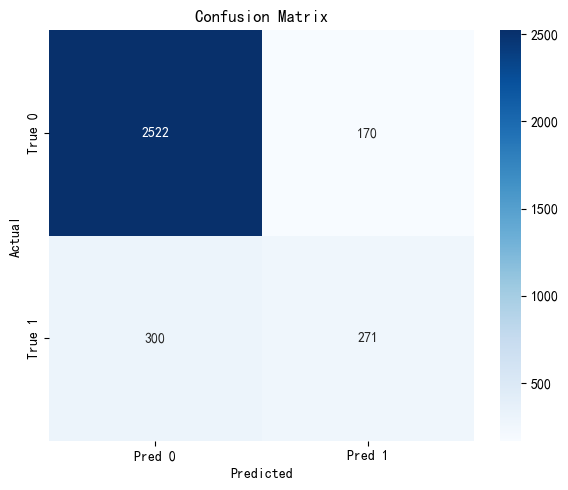

In [ ]:
# comment:: 刚刚还在疑惑为什么测试不用dataloader

model.eval()

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=0)
recall = recall_score(all_labels, all_preds, zero_division=0)
f1 = f1_score(all_labels, all_preds, zero_division=0)
conf_mat = confusion_matrix(all_labels, all_preds)

print("====== ")
print(f"准确率 (Accuracy): {accuracy:.4f}")
print(f"精确率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f}")
print(f"F1 分数: {f1:.4f}")
print("混淆矩阵 (Confusion Matrix):")
print(conf_mat)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
